This jupyter notebook will explore trends in pre and post disturbance SWE by running a timeseries analysis for:
- SWE pre and post fire, compared temporally for values before and after the fire
- SWE pre and post fire, compared spatially to nearby fire locations (to try to take annual precipitation into account)
- SWE pre and post fire, compared for 5 years after fire
It will also display confidence intervals for each trend analysis run.
Lastly, we will also look at burn severity by comparing trends in SWE between sites with differing burn severities 

In [113]:
import sys

In [114]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from scipy.interpolate import interp1d
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from SNOTEL_splitter import splitFireSNOTEL
%matplotlib inline

In [115]:
import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk') 

Before running this at all locations, we will start with looking at one: Harts Pass

In [116]:
site = 'Sentinel Butte'
paired = 'Gold Axe Camp'
years = 3
# fire locations
fire_sites = {'Sentinel Butte':'Gold Axe Camp', # apparent postive/null
              'Grouse Camp':'Trough', # apparent negative
              'Harts Pass':'Lyman Lake', # apparent positive/null
              'Three Creeks Meadow': 'Salt Creek Falls', # apparent negative/null
              'Pope Ridge': 'Blewett Pass'}# apparent negative/null
# fire_sites = {'Sentinel Butte':'Gold Axe Camp', 
#               'Grouse Camp':'Trough', 
#               'Harts Pass':'Rainy Pass', # apparent postive/null
#               'Three Creeks Meadow': 'Irish Taylor', # apparent postive/null
#               'Pope Ridge': 'Trinity'} # apparent postive/null
filepath = r'C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565_project\data\fire_sites'
disruption_dates = pd.read_excel(os.path.join(filepath,'snotel_fire_data.xlsx'))
variable = 'swe'


def getSites(site, paired, fire_dict=fire_sites, filepath=filepath, disruption_dates=disruption_dates, variable=variable,postyrs=5):
    """getSites will return filtered dataframes for the inputed site and its paired site, and can filter 
       to particular number of years after the disturbance

    Args:
        site (str): site of interest
        paired (str): paired site
        fire_dict (dict): dict containing sites and paired sites. Defaults to fire_sites.
        filepath (str): Path to data location. Defaults to filepath.
        disruption_dates (df): df containing fire start date and intensity values. Defaults to disruption_dates.
        variable (str): swe or depth. Can be adapted set of variables of interest. Defaults to swe.
        postyrs (int, optional): number of years after distrubance to report data. Defaults to 5.

    Returns:
        [type]: [description]
    """
    melt=False
    if variable == 'meltdates':
        variable = 'swe_meltdates'
        melt = True
    df_b, df_a = splitFireSNOTEL(site,fire_sites,variable,disruption_dates,filepath)
    df_paired_b, df_paired_a = splitFireSNOTEL(paired,fire_sites,variable,disruption_dates,filepath)
    if melt is False:
        fire_year = min(df_a.index.year)
        if postyrs != 'max':
            df_a = df_a.loc[dt.date(fire_year,10,1):dt.date(fire_year+postyrs,9,30)]
            df_paired_a = df_paired_a.loc[dt.date(fire_year,10,1):dt.date(fire_year+postyrs,9,30)]
        # remove 2015 as exceptionally dry year
        for df in [df_b,df_a,df_paired_a,df_paired_b]:
            df = df[df.index.year != 2015]
        if len(df_paired_b) > len(df_b):
            min_date = min(df_b.index)
            df_paired_b = df_paired_b.loc[df_paired_b.index > min_date]
        elif len(df_b) > len(df_paired_b):
            min_date = min(df_paired_b.index)
            df_b = df_b.loc[df_b.index > min_date]
    else:
        if postyrs != 'max':
            df_a = df_a[df_a['water_year'] < (min(df_a['water_year']+postyrs))]
            df_paired_a = df_paired_a[df_paired_a['water_year'] < (min(df_paired_a['water_year']+postyrs))]
        # remove 2015 as exceptionally dry year
        for df in [df_b,df_a,df_paired_a,df_paired_b]:
            df = df[df['water_year']!= 2015]
        if len(df_paired_b) > len(df_b):
            min_date = min(df_b['water_year'])
            df_paired_b = df_paired_b.loc[df_paired_b['water_year'] > min_date]
        elif len(df_b) > len(df_paired_b):
            min_date = min(df_paired_b['water_year'])
            df_b = df_b.loc[df_b['water_year'] > min_date]
        
    print('Filtering to {} years after fire...'.format(postyrs))
    print('Done!')
    return df_b, df_a, df_paired_b, df_paired_a

In [117]:
df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, variable='meltdates',postyrs=5)
df_a

Sentinel Butte for swe
swe_meltdates
Sentinel Butte for swe
swe_meltdates
Filtering to 5 years after fire...
Done!


,water_year,last_snow,DOWY
12,2016,2016-04-16,198
13,2017,2017-05-05,216
14,2018,2018-05-06,217
15,2019,2019-05-05,216
16,2020,2020-05-08,220


In [227]:
def boxplotSWE(ax, before, after, paired_before, paired_after,postyrs=5):
    # remove 0s
    pltlabels = ['pre-fire', '{} years\npost-fire'.format(postyrs),'pre-fire paired', '{} years\npost-fire paired'.format(postyrs)]
    ax.boxplot([before[before['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                after[after['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                paired_before[paired_before['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna(),
                paired_after[paired_after['SNOTEL:WTEQ_D']!=0]['SNOTEL:WTEQ_D'].dropna()], labels = pltlabels)
    ax.set_xlabel(site+'                                   '+paired, fontdict={'weight':'bold'})
    ax.set_ylabel('SWE [mm]')
    ax.set_title('SWE box plots for {} and {}'.format(site, paired))
    return ax


In [228]:
def boxplotDOWY(ax, before, after, paired_before, paired_after,postyrs=5):
    # remove 0s
    pltlabels = ['pre-fire', '{} years\npost-fire'.format(postyrs),'pre-fire paired', '{} years\npost-fire paired'.format(postyrs)]
    ax.boxplot([before['DOWY'],
                after['DOWY'],
                paired_before['DOWY'],
                paired_after['DOWY']], labels = pltlabels)
    ax.set_xlabel(site+'                                   '+paired, fontdict={'weight':'bold'})
    ax.set_ylabel('Day of Water Year')
    ax.set_title('Snow disappearance date box plots for {} and {}'.format(site, paired))
    return ax

In [224]:
def plotSWE(ax, before, after, site, paired=False):
    """plotSWE will plot mean April 1 SWE prior to the disturbance event against post disturbance SWE.

    Args:
        ax (axis): axis for plotting purposes
        before (df): pre-disturbance df
        after (df): post-distrubance df
        site (str): site name
        paired (bool, optional): If location is paired, set to true. Defaults to False.
    """
    for i,year in enumerate(after.index.year.unique()):
        # water_year_df_b = df_b.loc[dt.date(year,10,1):dt.date(year+1,9,30)].reindex()
        water_year_df_a = after.loc[dt.date(year,10,1):dt.date(year+1,9,30)].reset_index()
        # plt.plot(water_year_df_b.index, water_year_df_b['SNOTEL:WTEQ_D'])
        ax.plot(water_year_df_a.index, water_year_df_a['SNOTEL:WTEQ_D'], lw=1, label = '{} yr post-fire'.format(i))
    mean_swe = []
    minyear = min(before.index.year.unique())
    maxyear = max(before.index.year.unique())
    for i,date in enumerate(before.loc[dt.date(minyear,10,1):dt.date(minyear+1,9,30)].index.date):
        if i == 0:
            print('Start date: '+str(date))
        daily_mean_swe = before[(before.index.month == date.month) & (before.index.day == date.day)]['SNOTEL:WTEQ_D'].mean()
        mean_swe.append(daily_mean_swe)
    mean_swe = pd.Series(mean_swe,name='mean_swe')
    mean_swe.plot(ax=ax,label='{}-{}\nMean SWE'.format(minyear,maxyear))
    ax.set_xlabel('Day of Water Year')
    ax.set_ylabel('SWE [mm]')
    max_swe=max(before['SNOTEL:WTEQ_D'].max(),after['SNOTEL:WTEQ_D'].max())
    ax.set_ylim(0,max_swe)
    if paired is True:
        site = 'Paired Location: '+site
    ax.set_title('Annual SWE Pre- and Post-Disturbance\n{}'.format(site))
    return ax

    

Sentinel Butte for swe
swe
Sentinel Butte for swe
swe
Filtering to 5 years after fire...
Done!
Sentinel Butte for swe
swe_meltdates
Sentinel Butte for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
Start date: 2010-10-02
Start date: 2010-10-01
Grouse Camp for swe
swe
Grouse Camp for swe
swe
Filtering to 5 years after fire...
Done!
Grouse Camp for swe
swe_meltdates
Grouse Camp for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
Start date: 1982-10-01
Start date: 1982-10-02
Harts Pass for swe
swe
Harts Pass for swe
swe
Filtering to 5 years after fire...
Done!
Harts Pass for swe
swe_meltdates
Harts Pass for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
Start date: 1982-10-01
Start date: 1982-10-02
Three Creeks Meadow for swe
swe
Three Creeks Meadow for swe
swe
Filtering to 5 years after fire...
Done!
Three Creeks Meadow for swe
swe_meltdates
Three Creeks Meadow for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
Start date: 1980-10-01
Start d

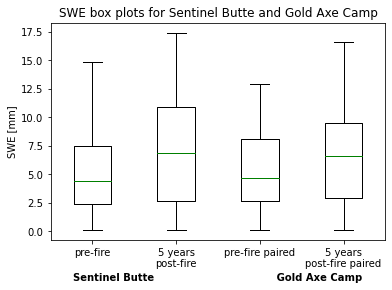

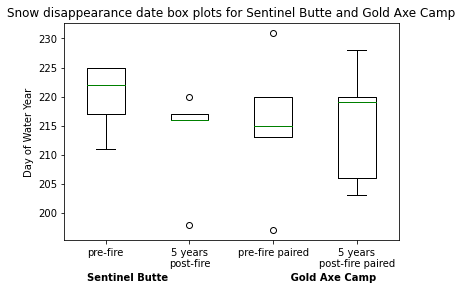

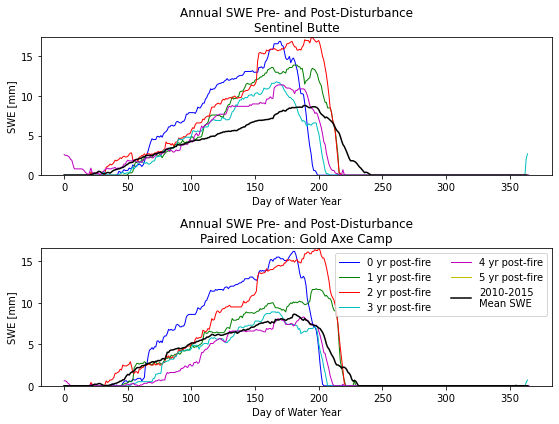

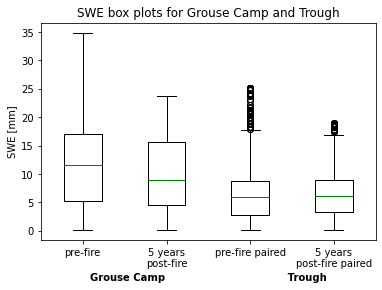

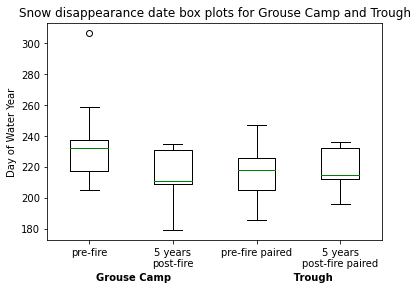

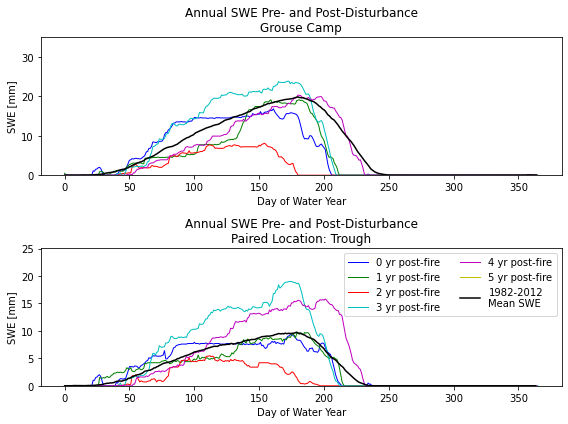

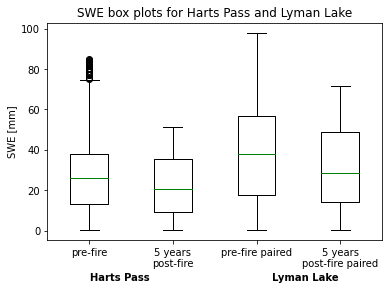

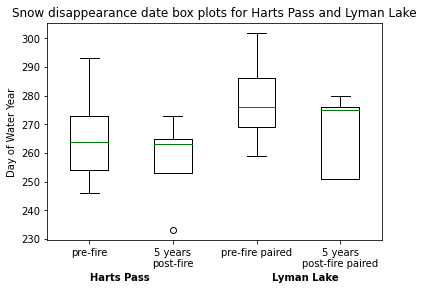

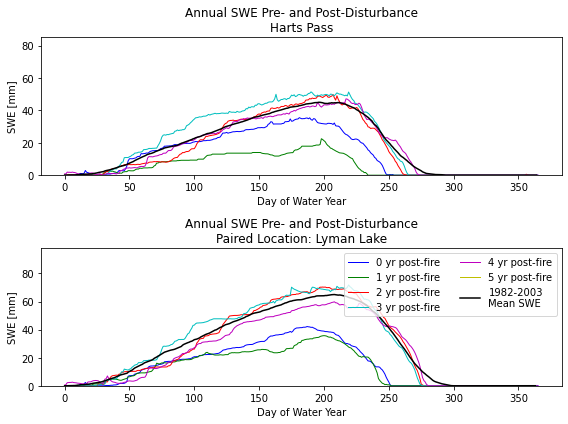

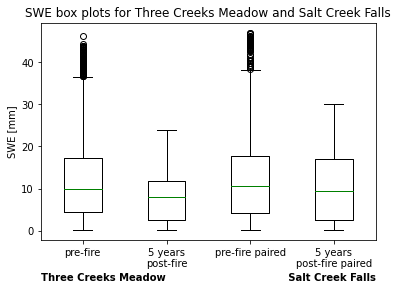

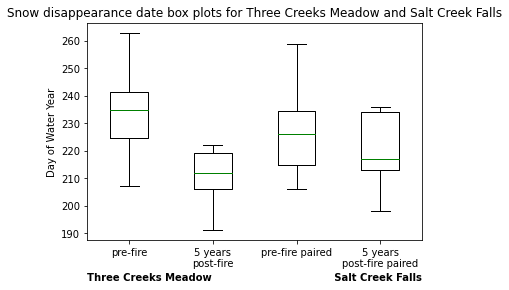

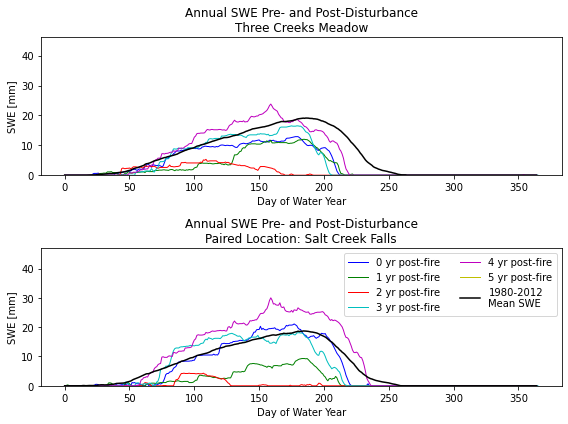

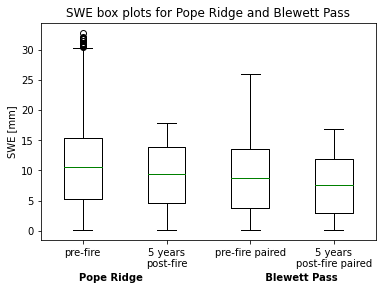

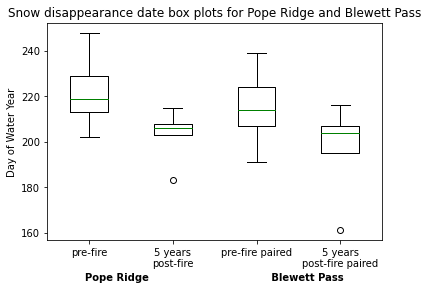

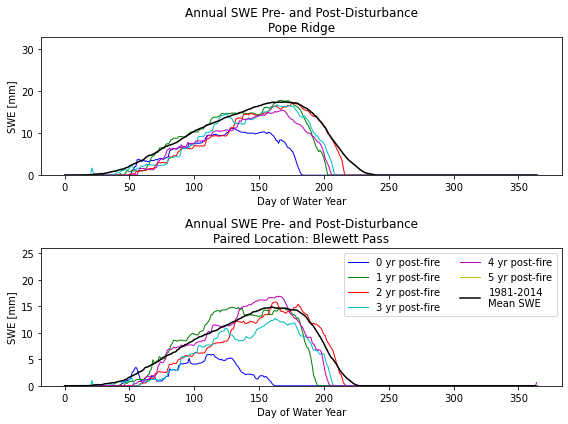

In [229]:
years = 5
for i,(site,paired) in enumerate(fire_sites.items()):
    df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired,postyrs=years)
    fig1, ax = plt.subplots()
    boxplotSWE(ax,df_b, df_a, df_paired_b, df_paired_a, postyrs=years)
    df_b2, df_a2, df_paired_b2, df_paired_a2 = getSites(site,paired, variable='meltdates',postyrs=years)
    fig2, ax = plt.subplots()
    boxplotDOWY(ax,df_b2, df_a2, df_paired_b2, df_paired_a2, postyrs=years)
    fig3, (ax1,ax2) = plt.subplots(2,figsize=(8,6), tight_layout=True)
    plotSWE(ax1,df_b,df_a,site)
    plotSWE(ax2,df_paired_b,df_paired_a,paired,paired=True)
    ax2.legend(loc='upper right',ncol=2)


Sentinel Butte for swe
swe
Sentinel Butte for swe
swe
Filtering to 5 years after fire...
Done!
Grouse Camp for swe
swe
Grouse Camp for swe
swe
Filtering to 5 years after fire...
Done!
Harts Pass for swe
swe
Harts Pass for swe
swe
Filtering to 5 years after fire...
Done!
Three Creeks Meadow for swe
swe
Three Creeks Meadow for swe
swe
Filtering to 5 years after fire...
Done!
Pope Ridge for swe
swe
Pope Ridge for swe
swe
Filtering to 5 years after fire...
Done!


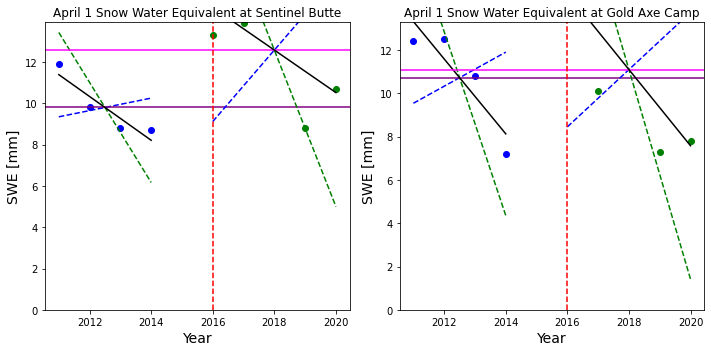

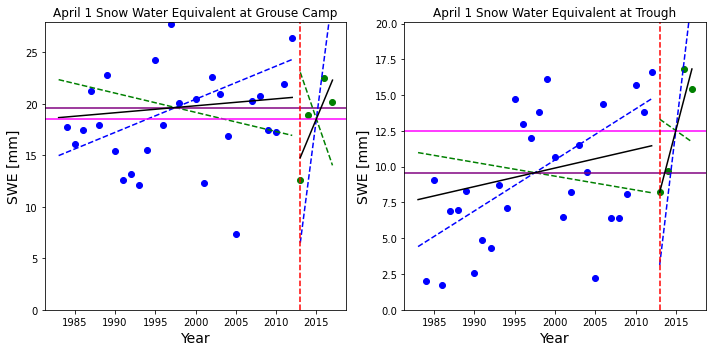

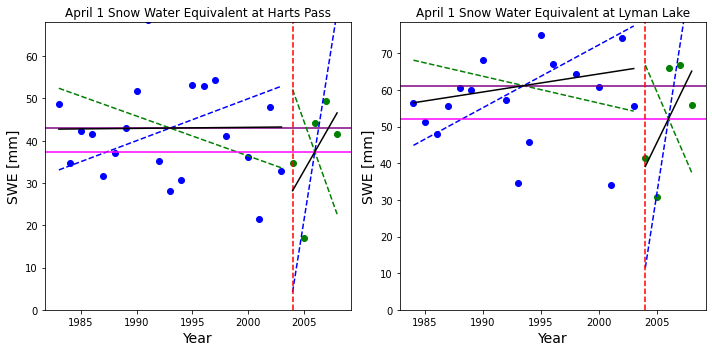

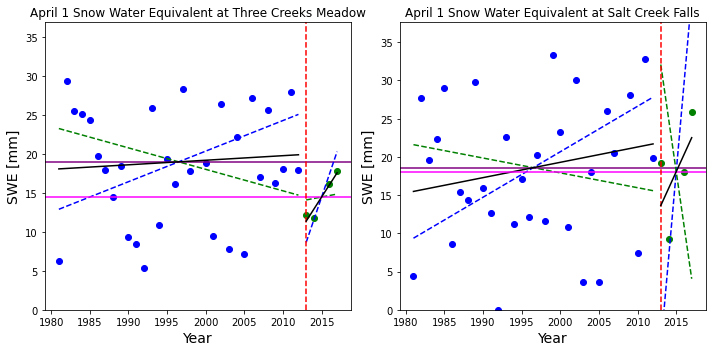

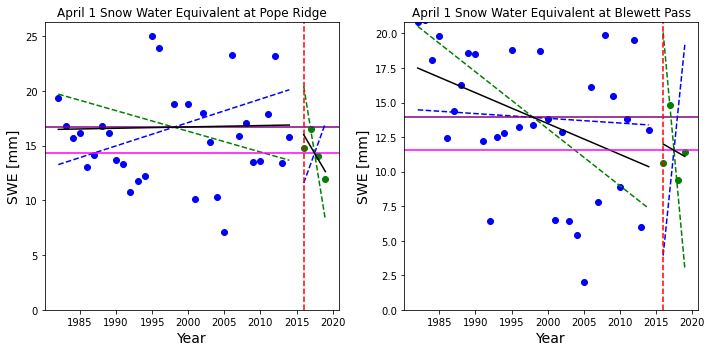

In [241]:
from matplotlib.ticker import MaxNLocator

for (site,paired) in fire_sites.items():
        fig, axs = plt.subplots(1,2, figsize=(10,5),tight_layout=True)
        axs = axs.flatten()
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)
        for i,df in enumerate([df_b, df_a, df_paired_b, df_paired_a]):
                if i == 2 or i ==3:
                        max_swe = max(df_paired_b['SNOTEL:WTEQ_D'].max(), df_paired_a['SNOTEL:WTEQ_D'].max())
                        title = paired
                        axis = 1
                else:
                        max_swe=max(df_b['SNOTEL:WTEQ_D'].max(),df_a['SNOTEL:WTEQ_D'].max())
                        title = site
                        axis=0
                if i == 0 or i==2:
                        color='purple'
                else: color='magenta'
                ax = axs[axis]
                ax.xaxis.get_major_locator().set_params(integer=True)
                # use the linear regression function
                swe_b = df[(df.index.month==4) & (df.index.day==1) & (df.index.year!=2015)].dropna()
                slope, intercept, rvalue, pvalue, stderr = stats.linregress(swe_b.index.year, swe_b['SNOTEL:WTEQ_D'])
                # Create points for the regression line
                x_before = np.linspace(swe_b.index.year.min(), swe_b.index.year.max(), swe_b.index.year.size) # x coordinates from min and max values 
                x_before = x_before[np.where(x_before != 2015)]
                y_before = slope * x_before + intercept # y coordinates using the slope and intercept from our linear regression
                # compute SST for col
                sst_x = np.sum( (swe_b.index.year - np.mean(swe_b.index.year))**2 )
                # Compute the standard error
                sigma = stderr * np.sqrt(sst_x)
                r_squared = rvalue**2
                # conf interval calculations
                sB1 = sigma/np.sqrt(sst_x)
                # t-value for alpha/2 with n-2 degrees of freedom
                alpha = 0.05
                n = len(x_before)
                dof = n - 2
                t = stats.t.ppf(1-alpha/2, dof)
                # compute upper and lower b1 limits
                B1_upper = slope + t * sB1
                B1_lower = slope - t * sB1
                # compute corresponding b0s
                B0_upper = swe_b['SNOTEL:WTEQ_D'].mean() - B1_upper*np.mean(swe_b.index.year)
                B0_lower = swe_b['SNOTEL:WTEQ_D'].mean() - B1_lower*np.mean(swe_b.index.year)
                # Plot the upper and lower confidence limits for the standard error of the gradient (slope)
                ax.plot([x_before.min(), x_before.max()],
                        [B0_upper + B1_upper*swe_b.index.year.min(), B0_upper + B1_upper*swe_b.index.year.max()] ,
                        '--b',
                        label='Upper B$_0$ confidence limit (95%)')
                ax.plot([x_before.min(), x_before.max()],
                        [B0_lower + B1_lower*swe_b.index.year.min(), B0_lower + B1_lower*swe_b.index.year.max()] ,
                        '--g',
                        label='Lower B$_0$ confidence limit (95%)')
                # plot up other items
                ax.axhline(swe_b['SNOTEL:WTEQ_D'].mean(),color=color, label='Mean SWE')
                if i in [1,3]:
                      ax.axvline(swe_b.index.year.min(),color='red',ls='--', label='Fire Year') 
                ax.plot(x_before,y_before,'k-',label='Linear Regression Trend')
                ax.scatter(swe_b.index.year,swe_b['SNOTEL:WTEQ_D'])
                ax.plot([],[],c='white', label='R$^2$ = {}'.format(np.round(r_squared,3)))
                ax.plot([],[],c='white', label='p < {}'.format(np.round(pvalue,3)))
                ax.set_ylim(0,max_swe*.8)
                ax.set_xlabel('Year', size=14)
                ax.set_ylabel('SWE [mm]', size=14)
                # ax.legend()
                ax.set_title('April 1 Snow Water Equivalent at {}'.format(title))

Sentinel Butte for swe
swe_meltdates
Sentinel Butte for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
FlignerResult(statistic=0.17874686564288628, pvalue=0.6724523834113043)
RanksumsResult(statistic=0.0, pvalue=1.0)
Grouse Camp for swe
swe_meltdates
Grouse Camp for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
FlignerResult(statistic=0.7247664913567096, pvalue=0.3945848503598465)
RanksumsResult(statistic=0.3890116312670917, pvalue=0.6972675422514331)
Harts Pass for swe
swe_meltdates
Harts Pass for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
FlignerResult(statistic=0.07992233824094941, pvalue=0.7774026831564248)
RanksumsResult(statistic=-1.3337300996963286, pvalue=0.18229232651282867)
Three Creeks Meadow for swe
swe_meltdates
Three Creeks Meadow for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
FlignerResult(statistic=0.00973188141133552, pvalue=0.921415932264753)
RanksumsResult(statistic=-0.7330317362268768, pvalue=0.463539073222558

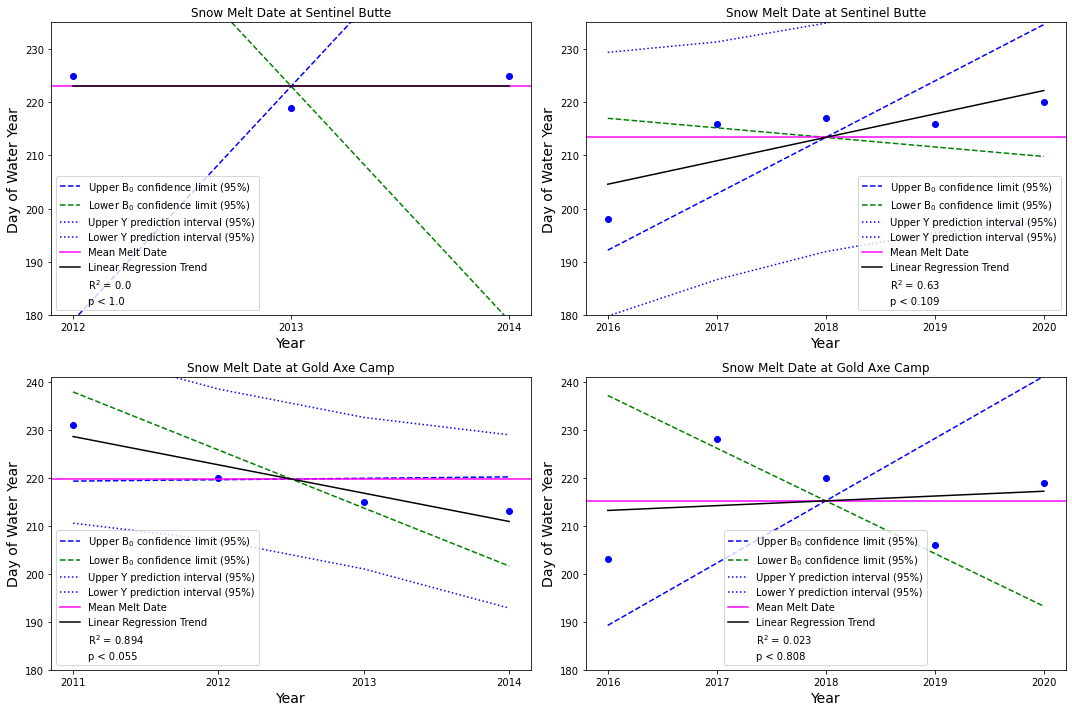

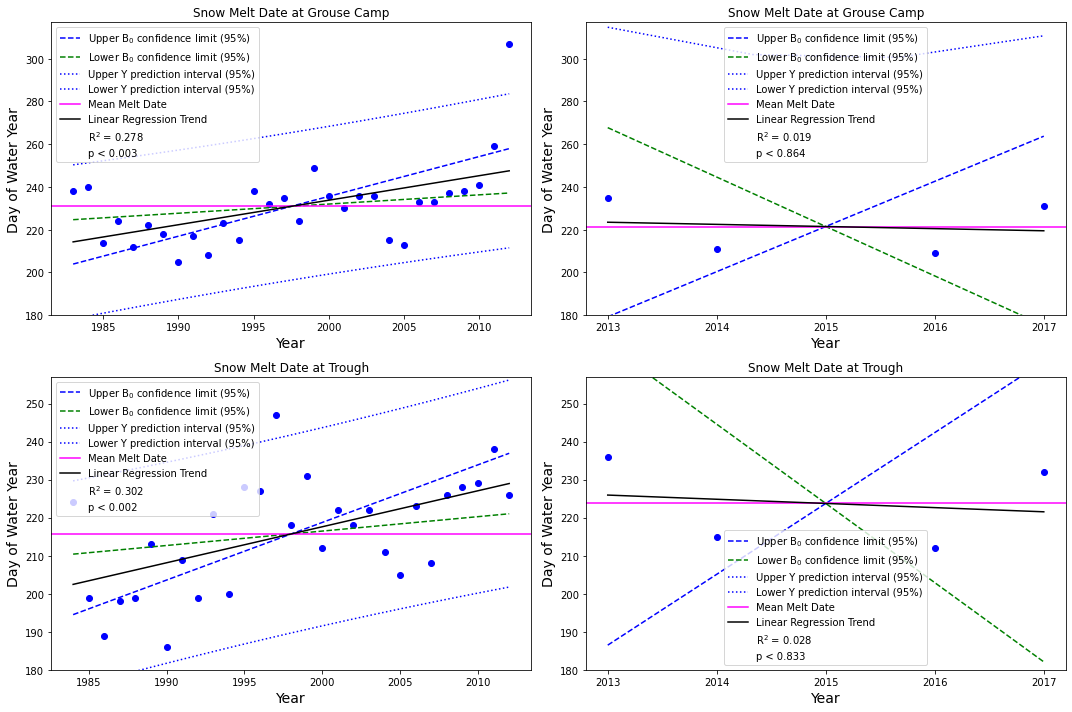

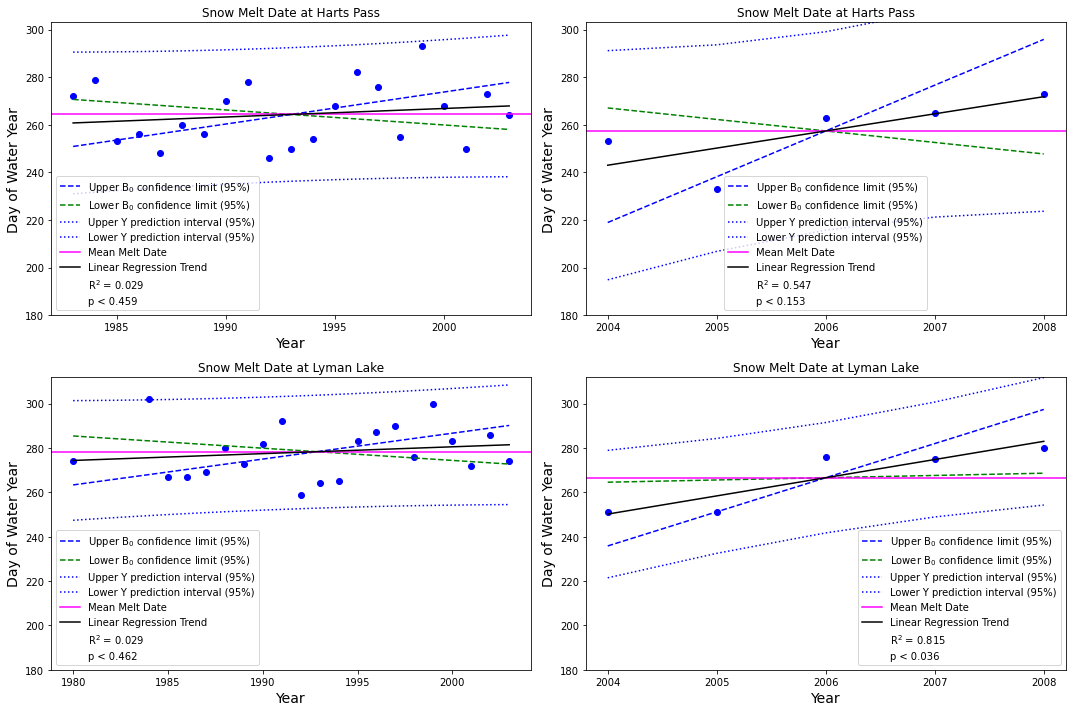

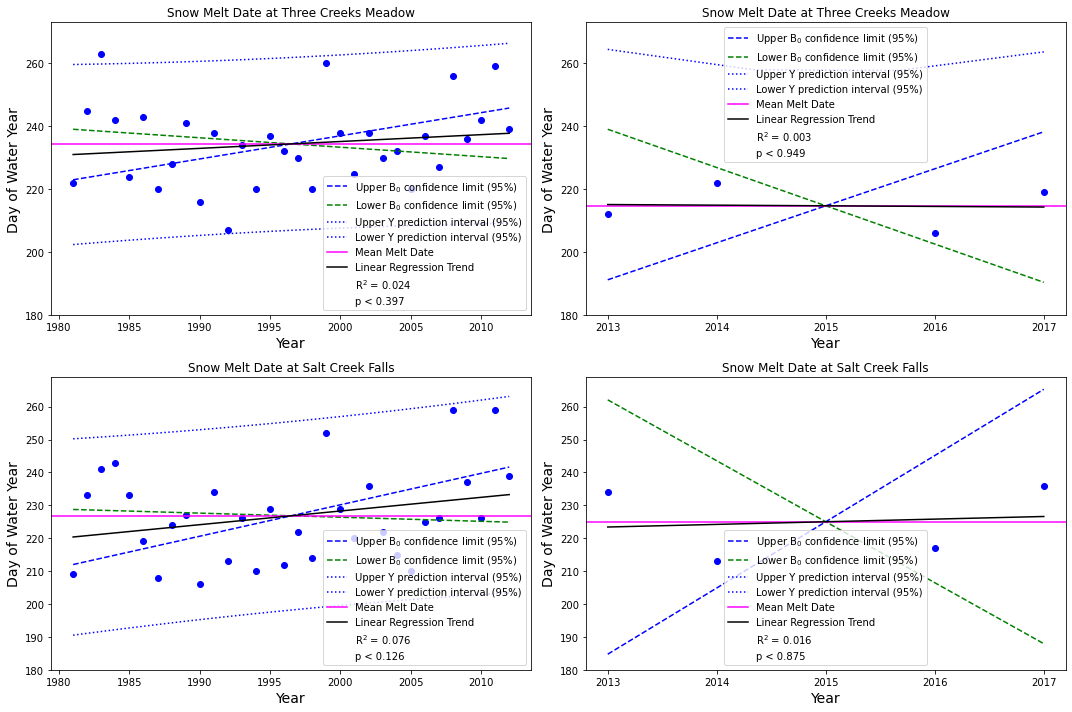

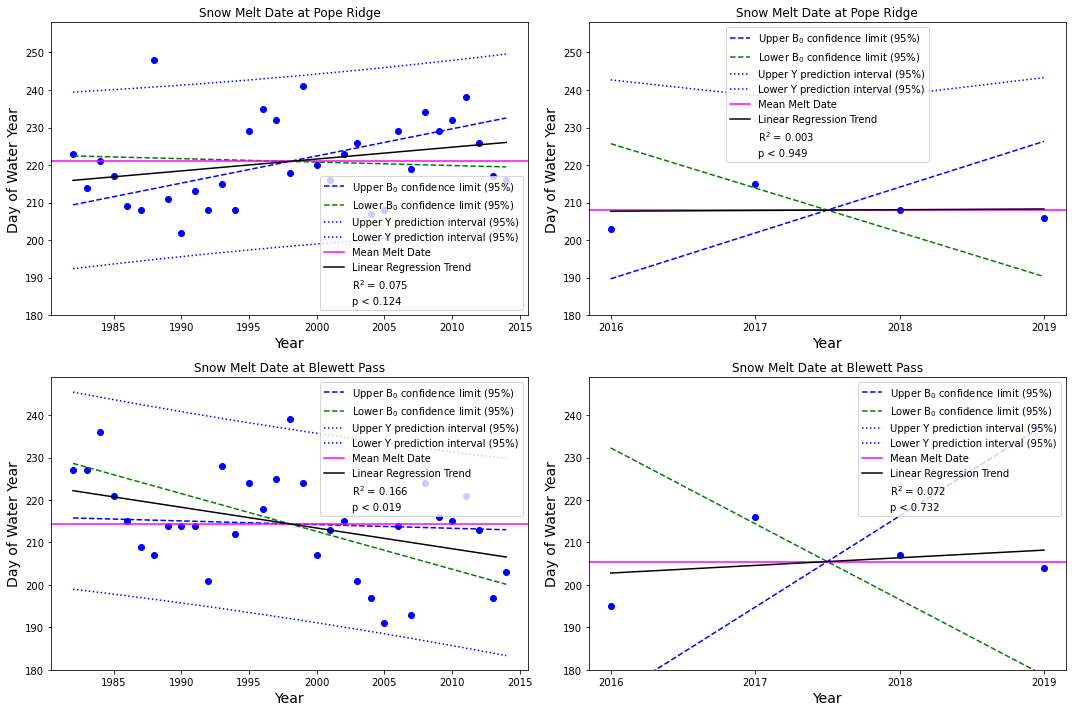

In [220]:
for (site,paired) in fire_sites.items():
        fig, axs = plt.subplots(2,2, figsize=(15,10),tight_layout=True)
        axs = axs.flatten()
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, variable='meltdates',postyrs=years)
        for i,df in enumerate([df_b, df_a, df_paired_b, df_paired_a]):
                if i == 2 or i ==3:
                        max_swe = max(df_paired_b['DOWY'].max(), df_paired_a['DOWY'].max())
                        title = paired
                else:
                        max_swe=max(df_b['DOWY'].max(),df_a['DOWY'].max())
                        title = site
                ax = axs[i]
                ax.xaxis.get_major_locator().set_params(integer=True)
                # use the linear regression function
                df = df[df['water_year']!=2015]
                slope, intercept, rvalue, pvalue, stderr = stats.linregress(df['water_year'], df['DOWY'])
                # Create points for the regression line
                x_before = np.linspace(df['water_year'].min(), df['water_year'].max(), df['water_year'].size) # x coordinates from min and max values
                x_before = x_before[np.where(x_before!=2015)] 
                y_before = slope * x_before + intercept # y coordinates using the slope and intercept from our linear regression
                # compute SST for col
                sst_x = np.sum( (df['water_year'] - np.mean(df['water_year']))**2 )
                # Compute the standard error
                sigma = stderr * np.sqrt(sst_x)
                r_squared = rvalue**2
                # t-value for alpha/2 with n-2 degrees of freedom
                alpha = 0.05
                n = len(x_before)
                dof = n - 2
                t = stats.t.ppf(1-alpha/2, dof)
                # conf interval calculations
                sB1 = sigma/np.sqrt(sst_x)

                # compute upper and lower b1 limits
                B1_upper = slope + t * sB1
                B1_lower = slope - t * sB1
                # compute corresponding b0s
                B0_upper = df['DOWY'].mean() - B1_upper*np.mean(df['water_year'])
                B0_lower = df['DOWY'].mean() - B1_lower*np.mean(df['water_year'])
                # Plot the upper and lower confidence limits for the standard error of the gradient (slope)
                ax.plot([x_before.min(), x_before.max()],
                        [B0_upper + B1_upper*df['water_year'].min(), B0_upper + B1_upper*df['water_year'].max()] ,
                        '--b',
                        label='Upper B$_0$ confidence limit (95%)')
                ax.plot([x_before.min(), x_before.max()],
                        [B0_lower + B1_lower*df['water_year'].min(), B0_lower + B1_lower*df['water_year'].max()] ,
                        '--g',
                        label='Lower B$_0$ confidence limit (95%)')
                # plot up other items
                ax.axhline(df['DOWY'].mean(),color='magenta', label='Mean Melt Date')
                ax.plot(x_before,y_before,'k-',label='Linear Regression Trend')
                ax.scatter(df['water_year'],df['DOWY'])
                ax.plot([],[],c='white', label='R$^2$ = {}'.format(np.round(r_squared,3)))
                ax.plot([],[],c='white', label='p < {}'.format(np.round(pvalue,3)))
                ax.set_ylim(180,max_swe+10)
                ax.set_xlabel('Year', size=14)
                ax.set_ylabel('Day of Water Year', size=14)
                ax.legend()
                ax.set_title('Snow Melt Date at {}'.format(title))

        print(stats.fligner(df_a['DOWY'],df_paired_a['DOWY'])) # test for similarity in variance
        print(stats.ranksums(df_paired_a['DOWY'], df_paired_b['DOWY'])) # test for equality of means between two samples

In [124]:
import seaborn as sns
import statsmodels.formula.api as smf

Sentinel Butte for swe
swe
Sentinel Butte for swe
swe
Filtering to 5 years after fire...
Done!
1.5400000000000063
Grouse Camp for swe
swe
Grouse Camp for swe
swe
Filtering to 5 years after fire...
Done!
-5.329999999999995
Harts Pass for swe
swe
Harts Pass for swe
swe
Filtering to 5 years after fire...
Done!
3.42499999999999
Three Creeks Meadow for swe
swe
Three Creeks Meadow for swe
swe
Filtering to 5 years after fire...
Done!
-3.333750000000002
Pope Ridge for swe
swe
Pope Ridge for swe
swe
Filtering to 5 years after fire...
Done!
-0.44545454545455065


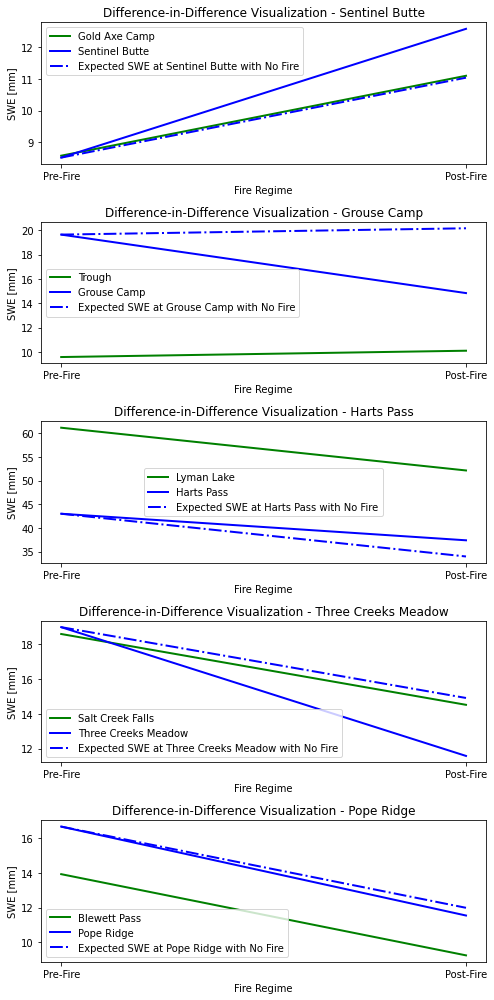

In [125]:
fig, axs = plt.subplots(5,figsize=(7,14),tight_layout=True)
for i,(site,paired) in enumerate(fire_sites.items()):
        
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)

        avg_4_1_swe_b = df_b[(df_b.index.month==4) & (df_b.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_b_paired = df_paired_b[(df_paired_b.index.month==4) & (df_paired_b.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_a = df_a[(df_a.index.month==4) & (df_a.index.day==1)]['SNOTEL:WTEQ_D'].mean()
        avg_4_1_swe_a_paired = df_paired_a[(df_paired_a.index.month==4) & (df_paired_a.index.day==1)]['SNOTEL:WTEQ_D'].mean()

        diff_in_diff = (avg_4_1_swe_a-avg_4_1_swe_b)-(avg_4_1_swe_a_paired-avg_4_1_swe_b_paired)
        print(diff_in_diff)

        axs[i].plot(['Pre-Fire', "Post-Fire"], [avg_4_1_swe_b_paired, avg_4_1_swe_a_paired], c= 'g',label=paired, lw=2)
        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_4_1_swe_b, avg_4_1_swe_a],c= 'b', label=site, lw=2)

        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_4_1_swe_b, avg_4_1_swe_b+(avg_4_1_swe_a_paired-avg_4_1_swe_b_paired)],
                label="Expected SWE at {} with No Fire".format(site), lw=2, color="b", ls="-.")
        axs[i].legend()
        axs[i].set_xlabel('Fire Regime')
        axs[i].set_ylabel('SWE [mm]')
        axs[i].set_title('Difference-in-Difference Visualization - {}'.format(site))

Sentinel Butte for swe
swe_meltdates
Sentinel Butte for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
-6.599999999999994
Grouse Camp for swe
swe_meltdates
Grouse Camp for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
-20.40919540229885
Harts Pass for swe
swe_meltdates
Harts Pass for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
4.7999999999999545
Three Creeks Meadow for swe
swe_meltdates
Three Creeks Meadow for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
-17.193749999999994
Pope Ridge for swe
swe_meltdates
Pope Ridge for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
-0.17575757575755802


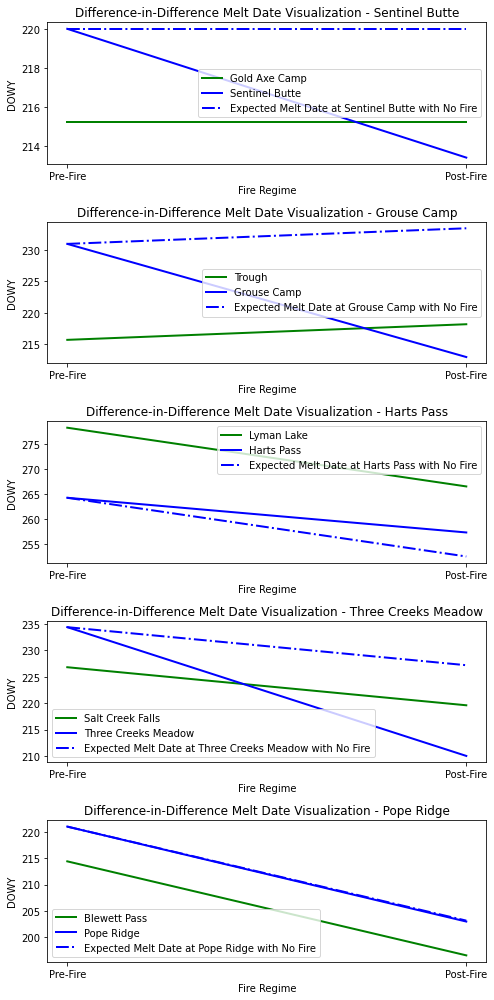

In [126]:
fig, axs = plt.subplots(5,figsize=(7,14),tight_layout=True)
for i,(site,paired) in enumerate(fire_sites.items()):
        
        df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, variable='meltdates', postyrs=years)

        avg_melt_b = df_b['DOWY'].mean()
        avg_melt_b_paired = df_paired_b['DOWY'].mean()
        avg_melt_a = df_a['DOWY'].mean()
        avg_melt_a_paired = df_paired_a['DOWY'].mean()

        diff_in_diff = (avg_melt_a-avg_melt_b)-(avg_melt_a_paired-avg_melt_b_paired)
        print(diff_in_diff)

        axs[i].plot(['Pre-Fire', "Post-Fire"], [avg_melt_b_paired, avg_melt_a_paired], c= 'g',label=paired, lw=2)
        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_melt_b, avg_melt_a],c= 'b', label=site, lw=2)

        axs[i].plot(["Pre-Fire", "Post-Fire"], [avg_melt_b, avg_melt_b+(avg_melt_a_paired-avg_melt_b_paired)],
                label="Expected Melt Date at {} with No Fire".format(site), lw=2, color="b", ls="-.")
        axs[i].legend()
        axs[i].set_xlabel('Fire Regime')
        axs[i].set_ylabel('DOWY')
        axs[i].set_title('Difference-in-Difference Melt Date Visualization - {}'.format(site))

In [172]:
df1['datetime'] = df1['datetime'].dt.year

In [182]:
diff_in_diff_results = {}
for i,(site,paired) in enumerate(fire_sites.items()):
    df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, postyrs=years)
    df1 = df_b[(df_b.index.month==4) & (df_b.index.day==1)].reset_index()
    df1 = df1[['datetime','SNOTEL:WTEQ_D']].dropna()
    df1['pre_post'] = 0
    df1['burned_unburned'] = 1

    df2 = df_paired_b[(df_paired_b.index.month==4) & (df_paired_b.index.day==1)].reset_index()
    df2 = df2[['datetime','SNOTEL:WTEQ_D']].dropna()
    df2['pre_post'] = 0
    df2['burned_unburned'] = 0

    df3 = df_a[(df_a.index.month==4) & (df_a.index.day==1)].reset_index()
    df3 = df3[['datetime','SNOTEL:WTEQ_D']].dropna()
    df3['pre_post'] = 1
    df3['burned_unburned'] = 1

    df4 = df_paired_a[(df_paired_a.index.month==4) & (df_paired_a.index.day==1)].reset_index()
    df4 = df4[['datetime','SNOTEL:WTEQ_D']].dropna()
    df4['pre_post'] = 1
    df4['burned_unburned'] = 0

    df = pd.concat([df1,df2,df3,df4])
    df = df.rename(columns = {'SNOTEL:WTEQ_D':'April1SWE'})
    results = smf.ols("April1SWE ~ datetime.dt.year+burned_unburned*pre_post",data=df).fit().summary()
    print(results)
    results_as_html = results.tables[1].as_html()
    diff_in_diff_ols = pd.read_html(results_as_html,header=0, index_col=0)[0]
    diff_in_diff_results[site] = diff_in_diff_ols
    post_fire_difference = diff_in_diff_ols.loc['burned_unburned:pre_post']['coef']
    post_fire_stderror = diff_in_diff_ols.loc['burned_unburned:pre_post']['std err']

    print('Post fire influence on SWE at {}: {} mm'.format(site,post_fire_difference))
    print('Post fire influence on SWE + standard error: {} mm'.format(post_fire_difference+post_fire_stderror))
    print('Post fire influence on SWE - standard error: {} mm'.format(post_fire_difference-post_fire_stderror))

Sentinel Butte for swe
swe
Sentinel Butte for swe
swe
Filtering to 5 years after fire...
Done!
                            OLS Regression Results                            
Dep. Variable:              April1SWE   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.313
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.305
Time:                        22:43:44   Log-Likelihood:                -53.316
No. Observations:                  20   AIC:                             114.6
Df Residuals:                      16   BIC:                             118.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [128]:
diff_in_diff_results

{'Sentinel Butte':                    coef  std err      t  P>|t|  [0.025  0.975]
 Intercept          8.58    1.740  4.932  0.000   4.892  12.268
 original          -0.06    2.460 -0.024  0.981  -5.276   5.156
 pre_post           2.52    2.460  1.024  0.321  -2.696   7.736
 original:pre_post  1.54    3.479  0.443  0.664  -5.836   8.916,
 'Grouse Camp':                     coef  std err      t  P>|t|  [0.025  0.975]
 Intercept           9.58    1.075  8.913  0.000   7.434  11.726
 original           10.07    1.520  6.625  0.000   7.035  13.105
 pre_post            0.52    2.844  0.183  0.855  -5.158   6.198
 original:pre_post  -5.33    4.022 -1.325  0.190 -13.360   2.700,
 'Harts Pass':                      coef  std err       t  P>|t|  [0.025  0.975]
 Intercept          61.205    3.088  19.819  0.000  54.992  67.418
 original          -18.205    4.315  -4.219  0.000 -26.886  -9.524
 pre_post           -9.045    6.905  -1.310  0.197 -22.937   4.847
 original:pre_post   3.425    9.742   

Next, we'll do a similar analysis but for snow melt out dates

In [188]:
import statsmodels.api as sm

Sentinel Butte for swe
swe_meltdates
Sentinel Butte for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
                            OLS Regression Results                            
Dep. Variable:               meltdate   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                 -0.167
Method:                 Least Squares   F-statistic:                    0.3559
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.836
Time:                        23:16:00   Log-Likelihood:                -68.071
No. Observations:                  19   AIC:                             146.1
Df Residuals:                      14   BIC:                             150.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------

C:\Users\dlhogan\miniconda3\envs\downgrade\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\dlhogan\miniconda3\envs\downgrade\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Post fire influence on melt date at Harts Pass: 4.8603 days
Post fire influence on melt date + standard error: 13.8093 days
Post fire influence on melt date - standard error: -4.0887 days
Three Creeks Meadow for swe
swe_meltdates
Three Creeks Meadow for swe
swe_meltdates
Filtering to 5 years after fire...
Done!
                            OLS Regression Results                            
Dep. Variable:               meltdate   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     5.278
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           0.000909
Time:                        23:16:00   Log-Likelihood:                -295.16
No. Observations:                  74   AIC:                             600.3
Df Residuals:                      69   BIC:                             611.8
Df Model:                           4                  

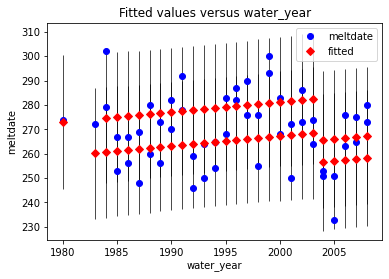

In [201]:
diff_in_diff_results = {}
for i,(site,paired) in enumerate(fire_sites.items()):
    
    df_b, df_a, df_paired_b, df_paired_a = getSites(site,paired, variable='meltdates',postyrs=years)
    df1 = df_b
    df1 = df1[['water_year','DOWY']].dropna()
    df1['pre_post'] = 0
    df1['original'] = 1

    df2 = df_paired_b
    df2 = df2[['water_year','DOWY']].dropna()
    df2['pre_post'] = 0
    df2['original'] = 0

    df3 = df_a
    df3 = df3[['water_year','DOWY']].dropna()
    df3['pre_post'] = 1
    df3['original'] = 1

    df4 = df_paired_a
    df4 = df4[['water_year','DOWY']].dropna()
    df4['pre_post'] = 1
    df4['original'] = 0

    df = pd.concat([df1,df2,df3,df4])
    df = df.rename(columns = {'DOWY':'meltdate'})
    results = smf.ols("meltdate ~ water_year + original*pre_post",data=df).fit()
    print(results.summary())
    if i == 2:
        sm.graphics.plot_fit(results, 1)
    results_as_html = results.summary().tables[1].as_html()
    diff_in_diff_ols = pd.read_html(results_as_html,header=0, index_col=0)[0]
    diff_in_diff_results[site] = [diff_in_diff_ols,results]
    post_fire_difference = diff_in_diff_ols.loc['original:pre_post']['coef']
    post_fire_stderror = diff_in_diff_ols.loc['original:pre_post']['std err']

    print('Post fire influence on melt date at {}: {} days'.format(site,post_fire_difference))
    print('Post fire influence on melt date + standard error: {} days'.format(post_fire_difference+post_fire_stderror))
    print('Post fire influence on melt date - standard error: {} days'.format(post_fire_difference-post_fire_stderror))

In [161]:
diff_in_diff_results['Grouse Camp'][0].loc['original:pre_post']

coef      -20.9303
std err    10.4840
t          -1.9960
P>|t|       0.0500
[0.025    -41.8750
0.975]      0.0150
Name: original:pre_post, dtype: float64